# Day 3 課題

### 目次
### - 1. Day 1, 2 の作業内容
### - 2. 特徴量選択
### - 3. 木モデルによる予測
### - 4. ニューラルネットワークによる予測

## 1. Day 1, 2 の作業内容
 
### 各変数について
- ID：不要と判断し削除
- name：用いる変数の中ではnameにのみ欠損値があった。欠損値が少ないため、削除して対応した。
- name_length：nameの単語数と成功確率に相関があるのではないかと考え、nameの単語数の変数を追加した。
- category：カテゴリーの種類によって成功確率に違いが見られた。ダミー変数を追加し予測に用いた。データ数の少ないカテゴリーもあり、予測に用いた場合、過学習の懸念がある。
- main_category：成功確率との関係が見られた。ダミー変数を追加し、予測に用いた。
- currency：成功確率との関係が見られた。ダミー変数を追加し、予測に用いた。
- country：成功確率との関係が見られた。ダミー変数を追加し、予測に用いたが、データ数の少ないカテゴリーもあり、予測に用いた場合、過学習の懸念がある。
- goal, usd_goal_real：分布について確認すると、goalの最大値100000000.0をとっているデータが多く見られた。これらは正常な値である可能性もあるが、設定された上限の値を超えていて、便宜的に100000000.0となっている可能性がある。そのためgoalがこれらの値となっているデータについては除外することとする。goalよりも通貨が揃っているusd_goal_realの方が適切と判断し、こちらを予測に用いている。
- deadline, launched：開始から、終了までの日数を求め、変数deltaとして追加した。deltaの外れ値について確認し、最大値91日のものがいくつか見られたが、クラウドファンディングの設定可能日数が91日であり、そのまま使用して問題ないと判断した。日数が0のデータも存在したが、実際に開始日と終了日を確認したところ、期間が一日未満であったため、こちらも問題ないと判断した。
- pledged, usd_peldged, usd_pledged_real, backers：クラウドファンディングの結果得られる値のため、今回は使用不可として削除
- state：目的変数、今回は結果の確定しているsuccessful, failedのみを用い、その他の値となっているデータは扱わないこととした。successful=1, failed=0 として数値に置き換えた。 

量的変数に関しては、標準化して計算に用いた。各変数名に_stdを付けたものを新たにdata frameに追加している。

### 各変数の相関
heatmup, 散布図行列を用いて、各変数の相関を調べた。
- name_lengthとstateには正の相関がみられ、名前の情報量が多い方が、成功しやすい傾向が示唆された。
- usd_goal_realとstateの相関係数は小さかった。目標金額と成功確率は関係しているように思われるが、相関係数には現れていない可能性もある。
- usd_goal_realとdeltaには小さな負の相関が見られた。直感に反するが、関係が相関係数で表現できていない可能性もある。

### ロジスティック回帰による予測
以下の二通の説明変数を用いて、stateの値を予測し、訓練誤差の評価、および交差検証による汎化誤差の評価を行った。
1. name_length_std, usd_goal_std, currencyおよび main_categoryのダミー変数, delta_std 
2. 上記にcountry, categoriのダミー変数を追加したもの
1の説明変数を用いたモデルでは、訓練データ、テストデータに対する正答率が共に64.9%であり、
2の説明変数を用いたモデルでは、それぞれ、67.2%, 67.1%であった。

### ロジスティック回帰の正則化項の検討
- より高い精度が見られた2の説明変数を用いて、ロジスティック回帰の正則化項を検討した。
- L1, L2どちらの場合でも正則化項を加えることで汎化誤差が小さくなった。
- 正則化項の係数となるパラメータalphaのチューニングを行い、誤差が小さくなるalphaの値を発見した。
- L1正則化において、学習後のモデルの各説明変数の重みを確認することで、特に重要な変数の確認を行った。

### サポートベクタ―マシンによる予測モデル構築
- カーネル関数はrbfを利用し、SVMによる予測モデルを構築した。
- グリッドサーチによるハイパーパラメータのチューニングを行い、C, gammaの良い値を見つけたが、計算時間の問題で十分ではない可能性がある。

これまでの検討では、正則化項つきのロジスティック回帰が最も精度の良いモデルとなっており、その汎化性能は正答率67%である。

#### これまでの処理を行ったData Frameを以下に示す。

In [16]:
# 使用するライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle 
from IPython.display import Image
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

In [2]:
#データの読み込み Day1でダミー変数の追加以外の処理を行った後のデータを読み込む。
df_day3 = pd.read_csv('Day1.csv')
df_day3.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,usd_goal_real_std,name_length,name_length_std,delta,delta_std
0,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 00:00:00,50000.0,2016-02-26 13:38:27,1,US,50000.00,0.025405,3,-0.954203,34,0.082298
1,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 00:00:00,1000.0,2014-12-01 18:30:44,1,US,1000.00,-0.050121,8,0.859112,19,-1.097677
2,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 00:00:00,12500.0,2013-03-09 06:42:58,1,US,12500.00,-0.032395,4,-0.591540,29,-0.311027
3,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03 00:00:00,5000.0,2017-04-05 19:44:18,1,GB,6469.73,-0.041690,9,1.221775,27,-0.468357
4,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17 00:00:00,250.0,2012-08-02 14:11:32,1,US,250.00,-0.051277,6,0.133786,14,-1.491002


In [3]:
#ダミー変数を追加したdf
df_day3_2=pd.read_csv('Day1_3.csv')
df_day3_2.head()

,name,deadline,goal,launched,state,usd_goal_real,usd_goal_real_std,name_length,name_length_std,delta,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,Monarch Espresso Bar,2016-04-01,50000.0,2016-02-26 13:38:27,1,50000.00,0.025405,3,-0.954203,34,...,0,0,0,0,0,0,0,0,0,1
1,Support Solar Roasted Coffee & Green Energy! ...,2014-12-21,1000.0,2014-12-01 18:30:44,1,1000.00,-0.050121,8,0.859112,19,...,0,0,0,0,0,0,0,0,0,1
2,Lisa Lim New CD!,2013-04-08,12500.0,2013-03-09 06:42:58,1,12500.00,-0.032395,4,-0.591540,29,...,0,0,0,0,0,0,0,0,0,1
3,Tombstone: Old West tabletop game and miniatur...,2017-05-03,5000.0,2017-04-05 19:44:18,1,6469.73,-0.041690,9,1.221775,27,...,0,0,0,0,0,0,0,0,0,0
4,Mike Corey's Darkness & Light Album,2012-08-17,250.0,2012-08-02 14:11:32,1,250.00,-0.051277,6,0.133786,14,...,0,0,0,0,0,0,0,0,0,1


## 2.特徴量選択

#### フィルター法、ラッパー法、LASSOによる特徴量の選択を行う。

### 2-1 フィルター法

散布図行列、相関係数のヒートマップを作成して、変数の相関を再度調べる。
散布図行列は実行時間の都合上、ダミー変数を除いている。

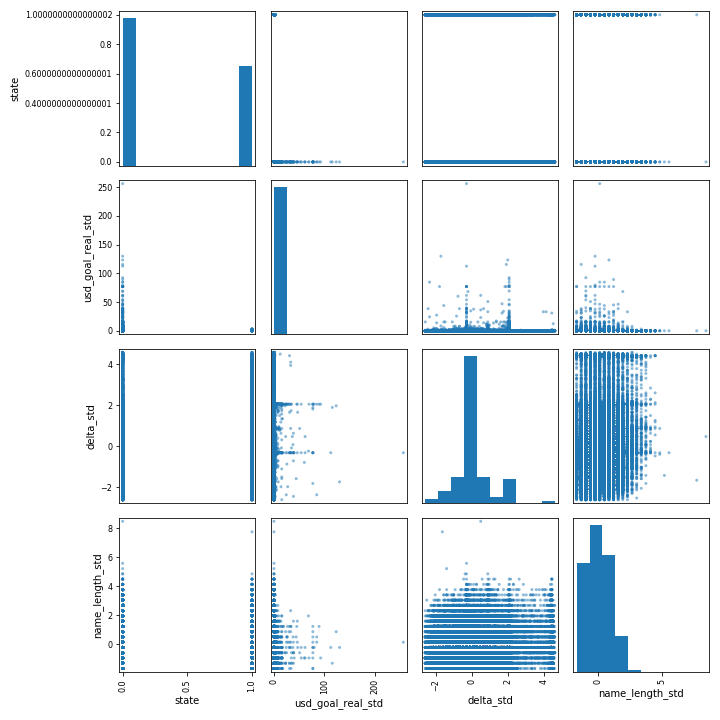

In [16]:
Image('Day1_matrix.png')

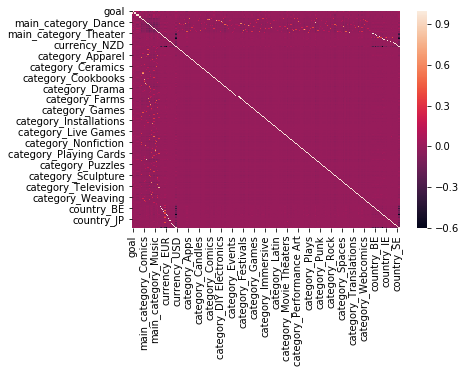

In [13]:
sns.heatmap(df_day3_2.corr())
plt.show()

currencyとcountryの一部の値の間、およびcategoryとmain_categoryの一部の間に相関がみられた。通貨と国、カテゴリーとメインカテゴリーは当然ある程度の関係を持っていると考えられるため、変数を減らしたい場合にはどちから一方ずつのみを用いることも有効であると考えられる。

### 2-2 ラッパー法

次にラッパー法による特徴量選択を試みる。すべての特徴量を用いて計算を行う。

In [17]:
from sklearn.feature_selection import RFECV

In [59]:
X = df_day3_2.drop(["state", "launched", "usd_goal_real", "name", "name_length", "deadline", "goal","delta"], axis=1)
y = df_day3_2["state"]
X.head()

,usd_goal_real_std,name_length_std,delta_std,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.025405,-0.954226,0.082299,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.050121,0.859104,-1.097680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.032395,-0.591560,-0.311027,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.041690,1.221770,-0.468358,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.051277,0.133772,-1.491007,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
# estimatorにモデルをセット
estimator2 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
rfecv2 = RFECV(estimator, cv=3, scoring='accuracy')

In [53]:
# fitで特徴選択を実行
rfecv2.fit(X, y)

RFECV(cv=3,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [68]:
#計算結果の保存、読み込み　必要に応じてコメントアウト

#with open('rfecv result', 'wb') as web:
#    pickle.dump(rfecv2, web)
    
with open('rfecv result', 'rb') as web:
    rfecv2 = pickle.load(web)

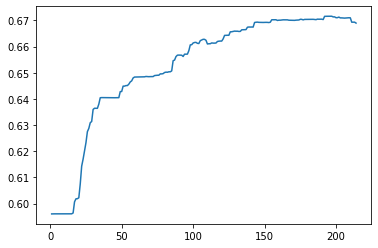

In [55]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
plt.show()

In [60]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得
# 値を反転させ、削除しても良い特徴の名前を取得する
remove_feature = X.columns[~rfecv2.support_]
remove_feature

Index(['currency_CAD', 'currency_CHF', 'category_Blues',
       'category_Children's Books', 'category_Comic Books',
       'category_Film & Video', 'category_Glass', 'category_Kids',
       'category_Movie Theaters', 'category_Plays', 'category_Poetry',
       'category_Quilts', 'category_Small Batch', 'category_World Music',
       'country_DE', 'country_SE', 'country_SG'],
      dtype='object')

ラッパー法による特徴量選択ができた。カテゴリーや通貨、国はデータ数が少ないものも含まれるため、今回は予測に不要という結果になったのではないかと推測される。

### 2-3 LASSOによる特徴選択

In [70]:
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=3)

# 今回は係数が1e-5以下である特徴を削除する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [71]:
# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [73]:
#削除しても良い特徴量を抽出
remove_feature = X.columns[~sfm.get_support()]
remove_feature

Index(['main_category_Film & Video', 'main_category_Games',
       'main_category_Journalism', 'currency_CAD', 'currency_GBP',
       'currency_NOK', 'currency_SGD', 'category_Children's Books',
       'category_Civic Design', 'category_Conceptual Art', 'category_Crafts',
       'category_Design', 'category_Fashion', 'category_Horror',
       'category_Photography', 'category_Small Batch', 'category_World Music',
       'country_AU', 'country_DE', 'country_DK', 'country_GB', 'country_SE',
       'country_US'],
      dtype='object')

LASSOによる特徴量選択を行うことができた。ラッパー法よりも計算時間は短かった。
不要な特徴量はフィルター方でも推測した通り、カテゴリー、メインカテゴリー、国、通貨の一部であった。係数の値の大きいものについて確認する。

In [86]:
# 説明変数の名前とその係数の絶対値をData Frameに
abs_coef = np.abs(sfm.estimator_.coef_)
d = np.array([X.columns.values, abs_coef])
df_coef = pd.DataFrame(d.T, columns=['name', "abs_coef"])
df_coef.head()


,name,abs_coef
0,usd_goal_real_std,0.0105319
1,name_length_std,0.0456952
2,delta_std,0.0542882
3,main_category_Art,0.0170072
4,main_category_Comics,0.149696


In [89]:
# abs_coefの値で並び替え
df_coef = df_coef.sort_values('abs_coef', ascending = False)
df_coef.head()

,name,abs_coef
113,category_Letterpress,0.365841
115,category_Literary Spaces,0.343227
154,category_Residencies,0.31523
53,category_Chiptune,0.31119
100,category_Hip-Hop,0.292933


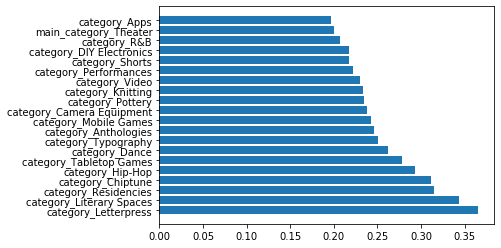

In [92]:
# 係数を棒グラフで表示
l = 20 #上位l件を表示
plt.barh(np.arange(0, l), df_coef.head(l)['abs_coef'], tick_label=df_coef.head(l)['name'])
plt.show()

カテゴリーの係数が大きいという結果になっていた。

## 3.木モデルによる予測

#### 決定木、ランダムフォレスト、アダブーストによる予測モデルの構築を行い、ハイパーパラメータのチューニング、モデルの評価を行う。

### 3-1 データの前処理
これまではcategory, currency等はOne-Hot エンコーディングによって扱っていたが、決定木を用いる際はLabelEncoderを使用して、低次元化し計算料の低減を図る。

In [63]:
#データの読み込み Day1でダミー変数の追加以外の処理を行った後のデータを読み込む。
# Day1では 全てのデータの値を用いて、標準化を行っていたので、一旦標準化を行った_stdの列を削除し、訓練データの値を基にやりなおす。(Day2指摘事項対応)
df_day3 = pd.read_csv('Day1.csv').drop(['usd_goal_real_std', 'name_length_std', 'delta_std'], axis=1)
df_day3.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_length,delta
0,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 00:00:00,50000.0,2016-02-26 13:38:27,1,US,50000.00,3,34
1,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 00:00:00,1000.0,2014-12-01 18:30:44,1,US,1000.00,8,19
2,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 00:00:00,12500.0,2013-03-09 06:42:58,1,US,12500.00,4,29
3,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03 00:00:00,5000.0,2017-04-05 19:44:18,1,GB,6469.73,9,27
4,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17 00:00:00,250.0,2012-08-02 14:11:32,1,US,250.00,6,14


In [64]:
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['category'])
df_day3['category'] = le.transform(df_day3['category'])

#main_categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['main_category'])
df_day3['main_category'] = le.transform(df_day3['main_category'])

#currencyに出てくるカテゴリを数値に変換
le = le.fit(df_day3['currency'])
df_day3['currency'] = le.transform(df_day3['currency'])

#categoryに出てくるカテゴリを数値に変換
le = le.fit(df_day3['country'])
df_day3['country'] = le.transform(df_day3['country'])

df_day3.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_length,delta
0,Monarch Espresso Bar,123,7,13,2016-04-01 00:00:00,50000.0,2016-02-26 13:38:27,1,22,50000.00,3,34
1,Support Solar Roasted Coffee & Green Energy! ...,58,7,13,2014-12-21 00:00:00,1000.0,2014-12-01 18:30:44,1,22,1000.00,8,19
2,Lisa Lim New CD!,72,10,13,2013-04-08 00:00:00,12500.0,2013-03-09 06:42:58,1,22,12500.00,4,29
3,Tombstone: Old West tabletop game and miniatur...,136,8,5,2017-05-03 00:00:00,5000.0,2017-04-05 19:44:18,1,9,6469.73,9,27
4,Mike Corey's Darkness & Light Album,90,10,13,2012-08-17 00:00:00,250.0,2012-08-02 14:11:32,1,22,250.00,6,14


In [65]:
X = df_day3.drop(['state', 'name', 'deadline', 'launched', 'goal'], axis=1)
y = df_day3['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
X.head()

,category,main_category,currency,country,usd_goal_real,name_length,delta
0,123,7,13,22,50000.00,3,34
1,58,7,13,22,1000.00,8,19
2,72,10,13,22,12500.00,4,29
3,136,8,5,9,6469.73,9,27
4,90,10,13,22,250.00,6,14


In [66]:
#量的変数の標準化
stdc =  StandardScaler()
stdc.fit(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])                                                                    
X_test.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_test.loc[:, ["usd_goal_real", "name_length", "delta"]])

C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### 3-2 決定木

In [61]:
clf_tree = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf_tree.fit(X_train, y_train)
print("score=", clf_tree.score(X_test, y_test))

score= 0.621438263229308


決定木による予測を行うことができた。決定木の可視化を試みる。

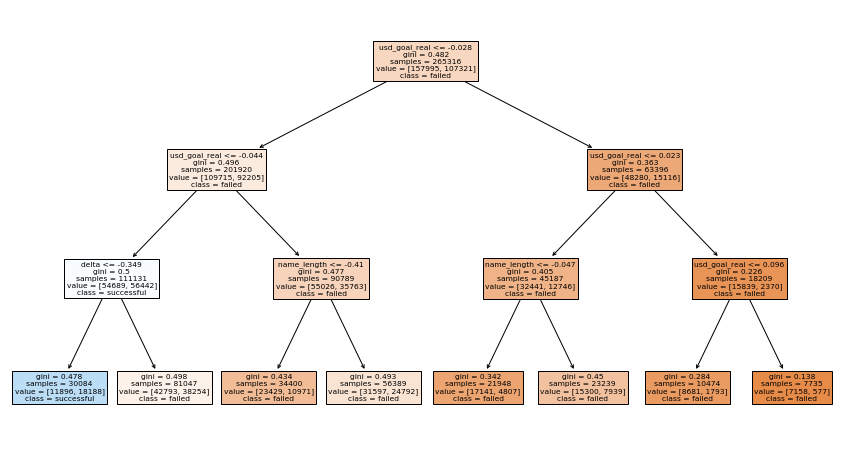

In [62]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plot_tree(clf_tree, feature_names=X_train.columns, ax=ax, class_names=["failed", "successful"], filled=True);

決定木を可視化することができた。

### 3-3 ランダムフォレストモデルの構築

In [67]:
clfrf = RandomForestClassifier(n_estimators=10, max_depth=5, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clfrf.fit(X_train, y_train)
print("score=", clfrf.score(X_test, y_test))

score= 0.6442183024272576


ランダムフォレストによる予測を行うことができた。精度向上のため、グリッドサーチによるハイパーパラメータのチューニングを行う。

In [68]:
#グリッドサーチによるパラメータの最適化
parameters = {'n_estimators':[10, 15, 20], 'max_depth':[2, 5, 10, 20], 'min_samples_leaf':[2, 5, 10], 'min_samples_split':[2, 5, 10]} 
model = RandomForestClassifier(criterion="gini",random_state=1234)
clfrf_best = GridSearchCV(model, parameters, cv=3,)
clfrf_best.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=1234, verbose=0,
                                              warm_start=False),
             iid

In [69]:
print(clfrf_best.best_params_, clfrf_best.best_score_)

{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 20} 0.6818586138792987


In [70]:
#計算結果の保存、読み込み　必要に応じてコメントアウト

with open('rf result', 'wb') as web:
    pickle.dump(clfrf_best, web)
    
with open('rf result', 'rb') as web:
    clfrf_best = pickle.load(web)

グリッドサーチによるパラメータのチューニングを行った。
max_depth, n_estimatos, min_samples_leafを更に値を大きくすることでさらに精度が向上する可能性がある。
チューニングしたパラメータを用いて、学習、最終テストデータの予測を行い、精度を評価する。

In [71]:
#チューニングしたパラメータを用いて学習を行い、最終テストデータを予測し精度を出す。
clf_rfb =  RandomForestClassifier(**clfrf_best.best_params_)
clf_rfb.fit(X_train, y_train)
print("識別精度=",clf_rfb.score(X_test, y_test))

識別精度= 0.680325644504749


In [72]:
#　混同行列を表示
y_est = clf_rfb.predict(X_test)
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)


              precision    recall  f1-score   support

      failed       0.70      0.80      0.75     39695
  successful       0.63      0.50      0.56     26635

    accuracy                           0.68     66330
   macro avg       0.67      0.65      0.65     66330
weighted avg       0.67      0.68      0.67     66330



,予測 = failed,予測 = successful
正解 = failed,31866,7829
正解 = successful,13375,13260


[0.20724826 0.13514987 0.02156941 0.0214184  0.32600345 0.10886608
 0.17974454]


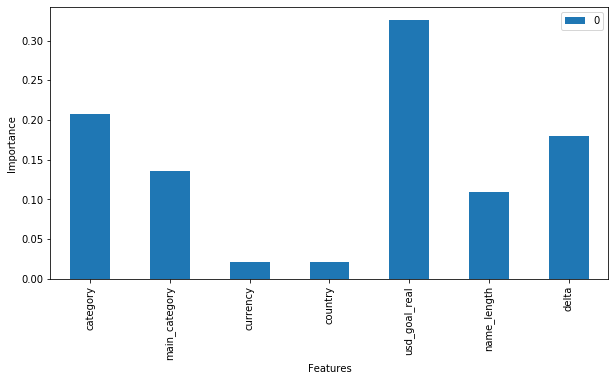

In [73]:
#各特徴量の重要度を表示
print(clf_rfb.feature_importances_)
pd.DataFrame(clf_rfb.feature_importances_, index=X.columns.values).plot.bar(figsize=(10,5))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

ランダムフォレストモデルはこれまでで最高の精度であった。変数の数を削減したこともあり、計算も高速であった。
各特徴量についてはcategory, usd_goal_realが重要で、currency, countyrはそれほど重要でないという結果であった。

### 3-4 アダブースト

In [74]:
clf_ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=2, random_state=1234,
                                                criterion="gini"),n_estimators=10, random_state=1234)
clf_ab.fit(X_train, y_train)
print("score=", clf_ab.score(X_test, y_test))

score= 0.6787577265189205


アダブーストによる予測を行うことができた。精度向上のため、グリッドサーチによるハイパーパラメータのチューニングを行う。

In [75]:
#グリッドサーチによるパラメータの最適化
parameters = {"base_estimator" : [DecisionTreeClassifier(max_depth=x) for x in range(5, 10)],}
model = AdaBoostClassifier(random_state=1234, n_estimators=15)
clf_ab_best = GridSearchCV(model, parameters, cv=3,)
clf_ab_best.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=15,
                                          random_state=1234),
             iid='warn', n_jobs=None,
             param_grid={'base_estimator': [DecisionTreeClassifier(class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=5,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decr...
                                            DecisionTreeClassifier(class_weight=None,
                                             

In [76]:
#計算結果の保存、読み込み　必要に応じてコメントアウト

with open('ad result', 'wb') as web:
    pickle.dump(clf_ab_best, web)
    
with open('ad result', 'rb') as web:
    clf_ab_best = pickle.load(web)

In [77]:
print(clf_ab_best.best_params_, clf_ab_best.best_score_)

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')} 0.682514435616397


In [78]:
#チューニングしたパラメータを用いて学習を行い、最終テストデータを予測し精度を出す。
clf_ab_best_2 = AdaBoostClassifier(**clf_ab_best.best_params_)
clf_ab_best_2.fit(X_train, y_train)
print("識別精度=",clf_ab_best_2.score(X_test, y_test))

識別精度= 0.6853610734207749


In [79]:
#　混同行列を表示
y_est = clf_ab_best_2.predict(X_test)
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)


              precision    recall  f1-score   support

      failed       0.72      0.78      0.75     39695
  successful       0.62      0.54      0.58     26635

    accuracy                           0.69     66330
   macro avg       0.67      0.66      0.66     66330
weighted avg       0.68      0.69      0.68     66330



,予測 = failed,予測 = successful
正解 = failed,31027,8668
正解 = successful,12202,14433


[0.24721302 0.11344525 0.02771938 0.03613539 0.32559132 0.0965251
 0.15337053]


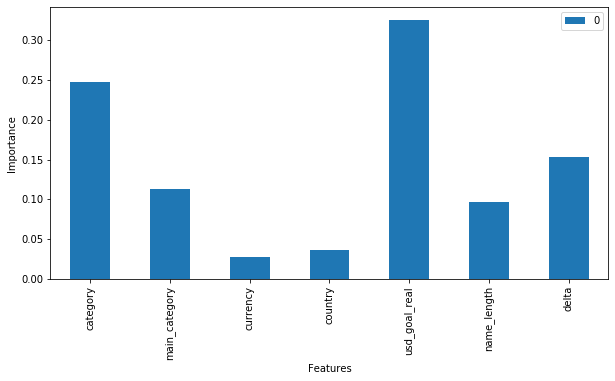

In [80]:
print(clf_ab_best_2.feature_importances_)
pd.DataFrame(clf_ab_best_2.feature_importances_, index=X.columns.values).plot.bar(figsize=(10,5))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

チューニングするパラメータ数を減らしたにも拘わらず、アダブーストモデルは、ランダムフォレストモデルよりもさらに高精度であった。
各特徴量についてはcategory, goal, 特に重要で、currency, countyrはそれほど重要でないという結果で、ランダムフォレストと似た結果であった。

## 4. ニューラルネットワークによる予測 

#### ニューラルネットワークによる予測モデルの構築を行い、モデルの評価を行う。

### 4-1 データの前処理
ラッパー法により選択された特徴量を用いる。

In [41]:
#ラッパー法による特徴量選択を行う前のデータフレーム
X = df_day3_2.drop(["state", "launched",  "name", "deadline", "goal", "usd_goal_real_std", "delta_std", "name_length_std"], axis=1)
y = df_day3_2["state"]
X.head()

,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,50000.00,3,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000.00,8,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12500.00,4,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6469.73,9,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250.00,6,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
#ラッパー法による特徴量選択を反映
X = X.drop(['currency_CAD', 'currency_CHF', 'category_Blues',
       'category_Children\'s Books', 'category_Comic Books',
       'category_Film & Video', 'category_Glass', 'category_Kids',
       'category_Movie Theaters', 'category_Plays', 'category_Poetry',
       'category_Quilts', 'category_Small Batch', 'category_World Music',
       'country_DE', 'country_SE', 'country_SG'], axis = 1)
X.head()

,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_US
0,50000.00,3,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000.00,8,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12500.00,4,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6469.73,9,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250.00,6,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
#yのOne-hotエンコーディング
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
print(type(y))
y

<class 'numpy.ndarray'>


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [44]:
#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

In [45]:
#量的変数の標準化
stdc =  StandardScaler()
stdc.fit(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_train.loc[:, ["usd_goal_real", "name_length", "delta"]])                                                                    
X_test.loc[:, ["usd_goal_real", "name_length", "delta"]] = stdc.transform(X_test.loc[:, ["usd_goal_real", "name_length", "delta"]])
X_train.head()

C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,usd_goal_real,name_length,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_US
155831,-0.041426,-1.317835,-0.939474,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
187150,-0.026568,-0.954873,-0.309452,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14843,-0.034951,-0.228947,0.005558,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
173910,-0.048622,0.134016,-0.624463,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258813,-0.042146,-0.228947,0.478074,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train
y_test = y_test

In [47]:
#モデルの構築

model = Sequential()
model.add(Dense(197, activation='relu', input_dim=197))
model.add(Dense(50, activation='relu', input_dim=197))
model.add(Dense(10, activation='relu', input_dim=50))
model.add(Dense(2, activation='softmax'))

# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [48]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=15,
          batch_size=20,validation_data=(X_test, y_test))


Train on 265316 samples, validate on 66330 samples
Epoch 1/15
265316/265316 [==============================] - 78s 293us/sample - loss: 0.6105 - accuracy: 0.6625 - val_loss: 0.6070 - val_accuracy: 0.6686
Epoch 2/15
265316/265316 [==============================] - 84s 316us/sample - loss: 0.6020 - accuracy: 0.6702 - val_loss: 0.5979 - val_accuracy: 0.6725
Epoch 3/15
265316/265316 [==============================] - 72s 271us/sample - loss: 0.5989 - accuracy: 0.6719 - val_loss: 0.5968 - val_accuracy: 0.6729
Epoch 4/15
265316/265316 [==============================] - 68s 255us/sample - loss: 0.5965 - accuracy: 0.6737 - val_loss: 0.6237 - val_accuracy: 0.6478
Epoch 5/15
265316/265316 [==============================] - 79s 296us/sample - loss: 0.5947 - accuracy: 0.6750 - val_loss: 0.5943 - val_accuracy: 0.6727
Epoch 6/15
265316/265316 [==============================] - 82s 310us/sample - loss: 0.5935 - accuracy: 0.6768 - val_loss: 0.5930 - val_accuracy: 0.6764
Epoch 7/15
265316/265316 [=====

In [50]:
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

In [49]:
#モデルの保存

# 保存
model.save('my_model.h5')
del model

# 読み込み
model = load_model('my_model.h5')

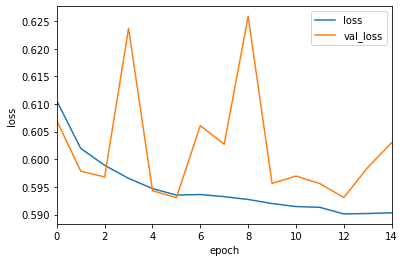

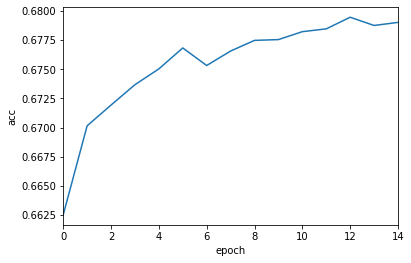

In [53]:
# 学習の過程をグラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df["accuracy"].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.show()

In [60]:
#ラベルの予測を行う。
y_est = np.argmax(model.predict(X_test),axis=1)
y_est

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [62]:
#評価のためone-hotエンコーディングを行っていないｙ_testを再度取得
y = df_day3_2["state"]
tmp1, tmp2, tmp3, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
y_test.values

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [63]:
#　混同行列を表示
target_names = ['failed', 'successful']
print(metrics.classification_report(y_test.values, y_est,target_names=target_names))
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

display(conf_mat_test)

              precision    recall  f1-score   support

      failed       0.71      0.78      0.74     39695
  successful       0.61      0.51      0.56     26635

    accuracy                           0.67     66330
   macro avg       0.66      0.65      0.65     66330
weighted avg       0.67      0.67      0.67     66330



,予測 = failed,予測 = successful
正解 = failed,31044,8651
正解 = successful,12926,13709


#### ニューラルネットワークによるモデルの構築を行い、精度を評価した。これまで行った学習では精度は67%であった。ノード数や層の数、その他のパラメータのチューニングも検討していきたい。


### [質問] ニューラルネットワークにおける、層の数やノードの数はどのようにして決めていけばよいのでしょうか？方針や指針、方法などあるのでしょうか。